##Домашнее задание № 2. Элементарные методы анализа временных рядов.

##Загрузим необходимые данные

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox

In [2]:
from pylab import rcParams

import seaborn as sns

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [3]:
# загрузим данные
!wget 'https://u.netology.ru/backend/uploads/lms/attachments/files/data/47497/1._Лекция_tsml.zip'

--2025-02-17 12:46:59--  https://u.netology.ru/backend/uploads/lms/attachments/files/data/47497/1._%D0%9B%D0%B5%D0%BA%D1%86%D0%B8%D1%8F_tsml.zip
Resolving u.netology.ru (u.netology.ru)... 213.180.193.247, 2a02:6b8::1da
Connecting to u.netology.ru (u.netology.ru)|213.180.193.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 769056 (751K) [application/x-zip-compressed]
Saving to: ‘1._Лекция_tsml.zip’

1._Лекция_tsml.zip  100%[===================>] 751.03K  1.02MB/s    in 0.7s    

2025-02-17 12:47:01 (1.02 MB/s) - ‘1._Лекция_tsml.zip’ saved [769056/769056]



In [4]:
# распакуем
import zipfile

with zipfile.ZipFile('/content/1._Лекция_tsml.zip', 'r') as zip_ref:
    zip_ref.extractall('unpacked_files')

В качестве ряда для анализа выберу monthly_boston_armed_robberies_j. Он мне кажется самым интересным.

In [5]:
# 2. ежемесячные_бостонские вооруженные_ ограбления_j
monthly_boston_armed_robberies_j = pd.read_csv('/content/unpacked_files/Series/monthly-boston-armed-robberies-j.csv')

In [6]:
series = monthly_boston_armed_robberies_j

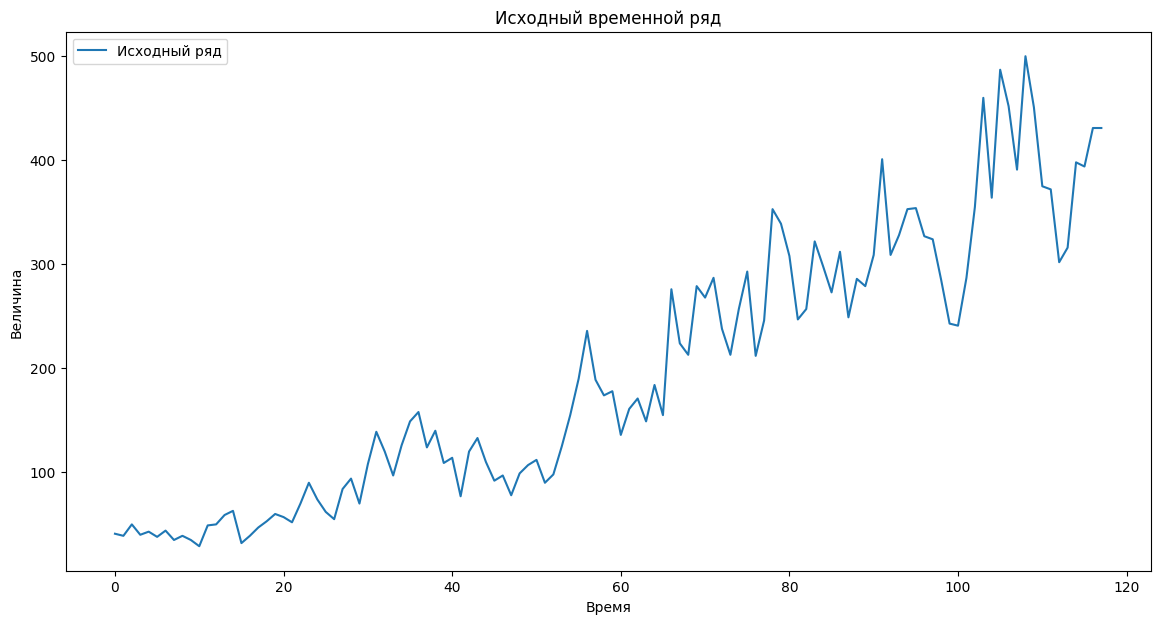

In [7]:
# еще раз на него посмотрим
plt.figure(figsize=(14, 7))
plt.plot(series['Count'], label='Исходный ряд')
#plt.plot(rolling_mean, label='Скользящее среднее', color='red')
#plt.plot(detrended, label='Detrended', color='green')
plt.title('Исходный временной ряд')
plt.xlabel('Время')
plt.ylabel('Величина')
plt.grid(False)
plt.legend()
plt.show()

##Holt Winters

Рассчитаем Стандартизованную оценку (Z-Score) для каждого наблюдения, то есть меру удаленности от Среднего значения (Mean)

In [9]:
series['Standardized_assessment'] = (series['Count'] -
                                     series['Count'].mean()) / series['Count'].std(ddof=0)
series.head()

,Month,Count,Standardized_assessment
0,1966-01,41,-1.217947
1,1966-02,39,-1.233633
2,1966-03,50,-1.147359
3,1966-04,40,-1.225790
4,1966-05,43,-1.202261


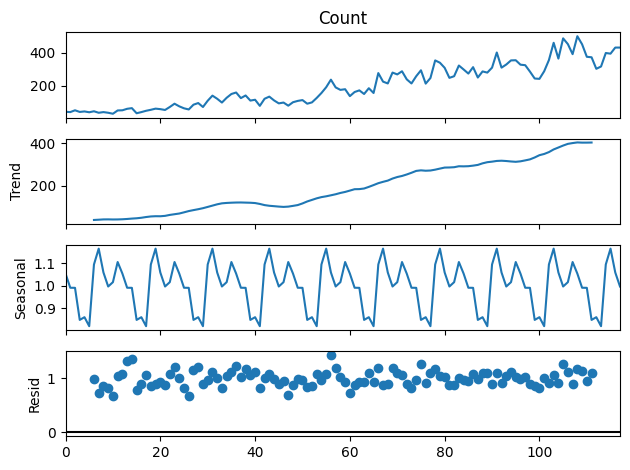

In [10]:
# разложим временной ряд на компоненты: тренд, сезонность и остатки
period = 12
decompose_result = seasonal_decompose(series['Count'],
                                      model='multiplicative',
                                      period=period)
decompose_result.plot()
plt.show()

Мне кажется, что прямо очень красиво такой сложный ряд разложился!

In [11]:
# разделим временной ряд на Train и Test
s_train = series['Count'][:int(0.8*len(series['Count']))]
s_test = series['Count'][int(0.8*len(series['Count'])):]

In [12]:
# создадим экземпляр класса Holt Winters
seasonal_periods = 12
model_triple = ExponentialSmoothing(series['Count'],
                                    seasonal_periods=seasonal_periods,
                                    trend='mul',
                                    seasonal='mul')
# обучим модель
model_triple_fit = model_triple.fit()

# получим предсказания на тестовом наборе
start = len(s_train)
end = len(series['Count'])-1
predictions = model_triple_fit.predict(start=start, end=end)

# получим предсказания на последующие периоды
next_periods = 24
predictions_next = model_triple_fit.predict(start=end, end=end+next_periods)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


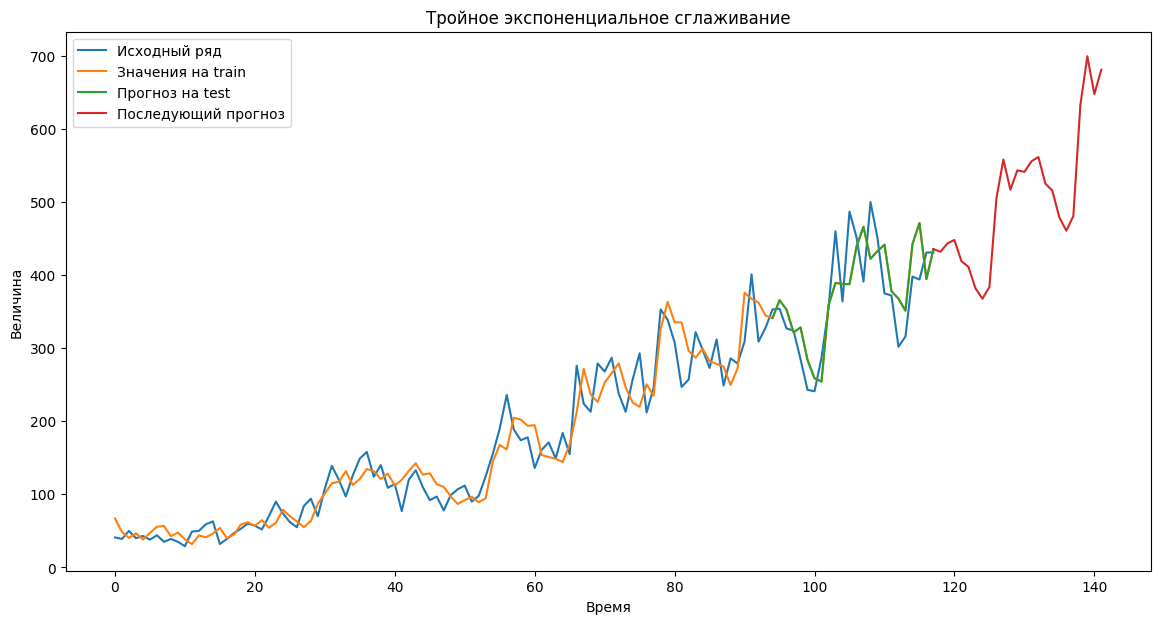

In [13]:
# нарисуем
plt.figure(figsize=(14, 7))
plt.plot(series['Count'], label='Исходный ряд')
plt.plot(model_triple_fit.fittedvalues, label='Значения на train')
plt.plot(predictions, label='Прогноз на test')
plt.plot(predictions_next, label='Последующий прогноз')
plt.xlabel('Время')
plt.ylabel('Величина')
plt.title('Тройное экспоненциальное сглаживание')
plt.legend()
plt.show()

In [14]:
# оценим модель по MAE
mae = np.mean(np.abs(predictions-s_test))
print('Mean Absolute Error:', mae)

Mean Absolute Error: 37.66827662604291


##Поиск по сетке. Экспоненциальное сглаживание Холта Винтера

Попробуем оптимизировать параметры

In [75]:
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

In [102]:
# одношаговый прогноз экспоненциального сглаживания Холта Винтера
def exp_smoothing_forecast(history, config):
    # будем считаль, что период мы уже угадали верно
    seasonal_periods = 12
    t, d, s, b, r = config
	  # определим модель
    model = ExponentialSmoothing(history,
                                trend=t,
                                damped=d,
                                seasonal=s,
                                seasonal_periods=seasonal_periods)
	  # обучим модель
    model_fit = model.fit(optimized=True,
                          use_boxcox=b,
                          remove_bias=r
                         )
	  # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

In [103]:
# создадим набор конфигураций экспоненциального сглаживания
def exp_smoothing_configs(seasonal=[None]):
    models = list()
	  # определим выборочный список настроек
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    b_params = [True, False]
    r_params = [True, False]
	  # создадим экземпляры конфигурации
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for b in b_params:
                    for r in r_params:
                        cfg = [t, d, s, b, r]
                        models.append(cfg)

    return models

In [104]:
# среднеквадратичная ошибка RMSE
def measure_rmse(actual, predicted):
	  return sqrt(mean_squared_error(actual, predicted))

In [105]:
# разделим временной ряд на Train и Test
def train_test_split(data, n_test):
    train = data[:int((1-n_test)*len(data))]
    test = data[int((1-n_test)*len(data)):]
    return train, test

In [106]:
# пошаговая проверка для одномерных данных
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
	  # разделенный набор данных
    train, test = train_test_split(data, n_test)
	  # начальная история с обучающим набором данных
    history = [x for x in train]
	  # пошаговое выполнение временного шага в тестовом наборе
    for i in range(len(test)):
        # обучение модели и составление прогноза по истории
        yhat = exp_smoothing_forecast(history, cfg)
        # сохраняем прогноз в списке прогнозов
        predictions.append(yhat)
		    # добавляем фактические данные в историю для следующего цикла
        history.append(test[i])

	  # оцениваем ошибку прогнозирования
    error = measure_rmse(test, predictions)
    print(error)

    return error

In [83]:
# оценка модели, в случае сбоя не возвращать None
def score_model(data, n_test, cfg, debug=False):

    result = None
	  # преобразуем коефигурацию в ключ
    key = str(cfg)

	  # показывать все предупреждения и завершать работу
    # с ошибкой при возникновении исключения при отладке
    if debug:
		    result = walk_forward_validation(data, n_test, cfg)
    else:
		    # один сбой во время проверки модели указывает на нестабильную конфигурацию
		    try:
			      # предупреждения показывать не будем
			      with catch_warnings():
				        filterwarnings('ignore')
                result = walk_forward_validation(data, n_test, cfg)
		    except:
			      error = None

	  # поищем интересный результат
	  if result is not None:
		    print(' > Model[%s] %.3f' % (key, result))

	  return (key, result)

In [76]:
# конфигурация поиска по сетке
def grid_search(data, cfg_list, n_test, parallel=True):
	  scores = None
	  if parallel:
		    # параллельное выполнение конфигураций
		    executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		    tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		    scores = executor(tasks)
	  else:
		    scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	  # удалим пустые результаты
	  scores = [r for r in scores if r[1] != None]
	  # отсортируем крнфигурации
	  scores.sort(key=lambda tup: tup[1])
	  return scores

In [88]:
# наш набор данных
data = series['Count'].tolist()

# разделим данные на Train и Test
n_test = 0.2

# конфигурации моделей
cfg_list = exp_smoothing_configs()

# выпоним поиск по сетке
scores = grid_search(data, cfg_list, n_test)
print('Конец!')

# ТОП-3
for cfg, error in scores[:3]:
		print(cfg, error)

[41, 39, 50, 40, 43, 38, 44, 35, 39, 35, 29, 49, 50, 59, 63, 32, 39, 47, 53, 60, 57, 52, 70, 90, 74, 62, 55, 84, 94, 70, 108, 139, 120, 97, 126, 149, 158, 124, 140, 109, 114, 77, 120, 133, 110, 92, 97, 78, 99, 107, 112, 90, 98, 125, 155, 190, 236, 189, 174, 178, 136, 161, 171, 149, 184, 155, 276, 224, 213, 279, 268, 287, 238, 213, 257, 293, 212, 246, 353, 339, 308, 247, 257, 322, 298, 273, 312, 249, 286, 279, 309, 401, 309, 328] [41, 39, 50, 40, 43, 38, 44, 35, 39, 35, 29, 49, 50, 59, 63, 32, 39, 47, 53, 60, 57, 52, 70, 90, 74, 62, 55, 84, 94, 70, 108, 139, 120, 97, 126, 149, 158, 124, 140, 109, 114, 77, 120, 133, 110, 92, 97, 78, 99, 107, 112, 90, 98, 125, 155, 190, 236, 189, 174, 178, 136, 161, 171, 149, 184, 155, 276, 224, 213, 279, 268, 287, 238, 213, 257, 293, 212, 246, 353, 339, 308, 247, 257, 322, 298, 273, 312, 249, 286, 279, 309, 401, 309, 328][353, 354, 327, 324, 285, 243, 241, 287, 355, 460, 364, 487, 452, 391, 500, 451, 375, 372, 302, 316, 398, 394, 431, 431] 
[353, 354, 32

In [85]:
# ТОП-3
for cfg, error in scores[:3]:
		print(cfg, error)

In [14]:
# grid search holt winter's exponential smoothing
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
	t,d,s,p,b,r = config
	# define model
	model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
	# fit model
	model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = exp_smoothing_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
	models = list()
	# define config lists
	t_params = ['add', 'mul', None]
	d_params = [True, False]
	s_params = ['add', 'mul', None]
	p_params = seasonal
	b_params = [True, False]
	r_params = [True, False]
	# create config instances
	for t in t_params:
		for d in d_params:
			for s in s_params:
				for p in p_params:
					for b in b_params:
						for r in r_params:
							cfg = [t,d,s,p,b,r]
							models.append(cfg)
	return models

if __name__ == '__main__':
	# define dataset
	data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
	print(data)
	# data split
	n_test = 4
	# model configs
	cfg_list = exp_smoothing_configs()
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)